In [1]:
import json
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import subprocess

## Reference cross sections

In [2]:
with open("../tables/Lambda.compt.gamma.json") as f:
    ref = json.load(f)['physics_vector']
ref_e = np.array(ref['energy'])
ref_xs = np.array(ref['xs_eloss'])

# NOTE: lambda prime tables are scaled by E
with open("../tables/LambdaPrim.compt.gamma.json") as f:
    ref = json.load(f)['physics_vector']
prime_e = np.array(ref['energy'])[1:]
prime_xs = np.array(ref['xs_eloss'])[1:] / prime_e

ref_e = np.concatenate([ref_e, prime_e])
ref_xs = np.concatenate([ref_xs, prime_xs])

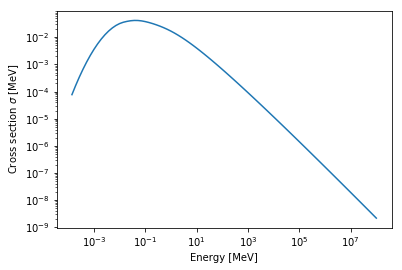

In [3]:
(fig, ax) = plt.subplots(1, 1, subplot_kw=dict(xscale='log', yscale='log'))
ax.plot(ref_e, ref_xs)
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel(r'Cross section $\sigma$ [MeV]');
fig.savefig(f"xs.pdf")

In [4]:
initial_energy = 100.0 # MeV

In [5]:
invmm_to_invcm = 10
xs_value = ref_xs[np.where(ref_e == initial_energy)][0] * invmm_to_invcm
xs_value

0.006512407533599999

## Run interactively

In [10]:
inp = {
    'grid_params': {
        'block_size': 256,
        'grid_size': 256,
    },
    'run': {
        'seed': 12345,
        'energy': initial_energy,
        'num_tracks': 256 * 256,
        'max_steps': 128,
        'tally_grid': {
            'size': 2048,
            'front': 0,
            'delta': 1,
        }
    }
}

results = subprocess.check_output([
    "ssh", "emmet", "~/.local/src/celeritas/build-opt/app/demo-interactor", "-"],
    input=json.dumps(inp).encode())
results = json.loads(results.decode())
print("Completed", tracks in", results['result']['total_time'], "seconds")

Completed in 2.883903569 seconds


In [11]:
tally = results['run']['tally_grid']
grid = np.arange(tally['size'] + 1) * tally['delta'] + tally['front']

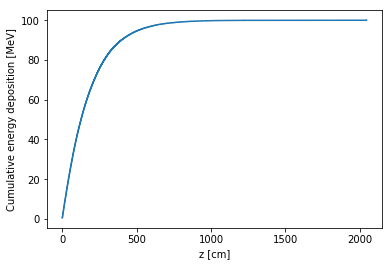

In [12]:
edep = np.array(results['result']['edep'])
(fig, ax) = plt.subplots()
ax.plot(grid[:-1], np.cumsum(edep), drawstyle='steps-post')
#ax.plot(grid, (1 - np.exp(-xs_value * grid)), color='r')
ax.set_xlabel('z [cm]')
ax.set_ylabel('Cumulative energy deposition [MeV]');
fig.savefig(f"edep-accum-{initial_energy:.0f}MeV.png", dpi=300)

In [18]:
# export to json
np.savetxt(f"edep-{initial_energy:.0f}MeV-{tally['delta']}cm.txt", edep)

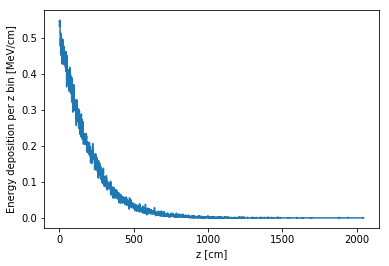

In [13]:
edep_per_dist = edep / tally['delta']
(fig, ax) = plt.subplots()
ax.plot(grid[:-1], edep_per_dist, drawstyle='steps-post')
ax.set_xlabel('z [cm]')
ax.set_ylabel('Energy deposition per z bin [MeV/cm]');
fig.savefig(f"edep-{initial_energy:.0f}MeV.png", dpi=300)

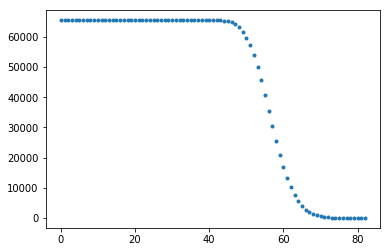

In [14]:
alive = np.array(results['result']['alive'])
time = np.array(results['result']['time'])
plt.plot(alive, '.');

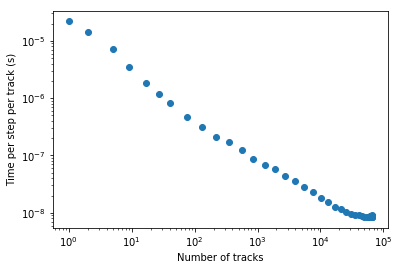

In [15]:
# Time per track
(fig, ax) = plt.subplots(1, 1, subplot_kw=dict(xscale='log', yscale='log'))
ax.scatter(alive[:-1], time / alive[:-1])
ax.set_xlabel('Number of tracks')
ax.set_ylabel('Time per step per track (s)');

## 1 MeV distributions

From the unit test.

In [24]:
nsamples = 10000
eps = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 182, 285, 235, 208, 220, 208, 183, 165, 177, 147, 135, 154, 139, 148, 150, 137, 134, 124, 132, 112, 126, 112, 122, 105, 124, 99, 98, 105, 110, 124, 109, 110, 108, 109, 111, 109, 102, 111, 94, 104, 126, 88, 107, 103, 97, 104, 116, 122, 107, 107, 114, 109, 98, 103, 110, 106, 104, 105, 109, 108, 102, 100, 115, 110, 118, 116, 117, 101, 121, 123, 100, 118, 118, 118, 107, 133, 120, 127, 113, 113])
costheta = np.array([49, 51, 40, 45, 49, 52, 52, 45, 54, 58, 52, 39, 38, 45, 60, 46, 49, 47, 34, 49, 38, 52, 58, 62, 59, 53, 50, 35, 44, 61, 58, 47, 50, 48, 59, 57, 50, 56, 54, 49, 50, 39, 56, 57, 68, 49, 64, 56, 59, 67, 75, 55, 77, 69, 76, 66, 60, 76, 80, 67, 74, 68, 79, 75, 77, 90, 80, 82, 96, 82, 82, 85, 94, 126, 117, 105, 111, 119, 136, 126, 137, 117, 157, 169, 144, 163, 167, 214, 203, 222, 202, 233, 257, 262, 289, 320, 353, 365, 412, 450])

In [17]:
grid = np.linspace(0, 1, len(eps) + 1)

Text(0.5, 0, '$E_{\\mathrm{out}} / E_{\\mathrm{in}}$')

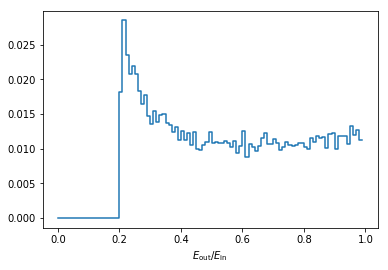

In [21]:
plt.plot(grid[:-1], eps / nsamples, drawstyle="steps-post")
plt.xlabel(r"$E_{\mathrm{out}} / E_{\mathrm{in}}$")

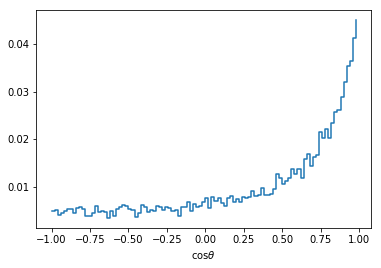

In [25]:
plt.plot((grid * 2 - 1)[:-1], costheta / nsamples, drawstyle="steps-post")
plt.xlabel(r"$\cos \theta$");